In [1]:
import numpy as np
import scipy
import pandas as pd
import statsmodels.api as sm
import researchpy as rp
import re
import scikit_posthocs
import seaborn as sns

from statsmodels.formula.api import ols
from glob import glob
from os.path import basename
from scipy.stats import friedmanchisquare
from scipy.stats import sem
from scipy.stats import ttest_ind
from scipy.stats import bootstrap
from sklearn import metrics


%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
def check_device(device, inRho, inLam, count):
    device_rho = device.loc[device.rho==inRho]

    device_rho_lam = device_rho.loc[device_rho.lam==inLam]

    for x in range(1, 21):
        subj = device_rho_lam.loc[device_rho_lam.subject == x]
       
        if (int(subj.count().values[0]) != 6) & (x!=2) & (x!=6) & (x!=19):
            print("subj ", x)
            print(subj.count().values[0])

In [3]:
def parse_data(files):
    """Parse the raw data
    
    Parameters
    ----------
    files : list
        List of filenames to parse
    
    Returns
    -------
    df : pd.DataFrame
        A DataFrame containing collision times and locations
    """
    df = []
    for file in files:
        subject = basename(file).split('_')[0]
        with open(file) as f:
            block = -1
            trial = -1
            while (line := f.readline().rstrip()):
                # A line is either a block,trial spec or a collision
                if ',' in line:
                    block_trial, time_collisions = line.split(': ')
                    block, trial = block_trial.split(', ')
                    time, collisions = time_collisions.split(', ')

                    df.append({
                        'subject': int(subject),
                        'block': int(block),
                        'trial': int(trial) ,
                        'time': float(time) if float(time) < 60 else 60,
                        'num_collisions' : int(collisions)
                    })

    return pd.DataFrame(df)

In [4]:
def parse_data_HMD(files):
    df = []
    for file in files:
        subject = basename(file).split('_')[0]
        with open(file) as f:
            block = -1
            trial = -1
            beginning = True
            while (line := f.readline().rstrip()):
                # A line is either a block,trial spec or a collision
                if '1,1' in line:
                    beginning = False
                if not beginning:
                    if '27,6' not in line:
                        if '(' not in line:
                            # No '(' means it's a trial spec:
                            try:
                                block, trial = line.split(',')
                            except ValueError as e:
                                print('Error:', e)
                                print(line)
                        else:
                            # Else it's a collision string: "time(x,y,z)":
                            time, x, y, z = re.findall(r"[-+]?\d*\.\d+|\d+", line)
                            # Add to a list of dicts, which will become our DataFrame:
                            df.append({
                                'subject': int(subject),
                                'block': int(block),
                                'trial': int(trial),
                                'time': float(time),
                                'x': float(x),
                                'y': float(y),
                                'z': float(z)
                            })

    df = pd.DataFrame(df)
    return df[df.block > 0]

In [5]:
def annotate_data(dff):
    """Add device, rho, lam"""
    df = dff.copy()
    # block 0 is the practice rounds. 1-9 is the 6x10, 10-18 is  10x16 and 19-27 is the 19x31
    df['device'] = 'N/A'
    df.loc[(df.block >= 1) & (df.block <= 9), 'device'] = '06x10'
    df.loc[(df.block >= 10) & (df.block <= 18), 'device'] = '10x16'
    df.loc[(df.block >= 19) & (df.block <= 27), 'device'] = '19x31'
    
    # Each device has 9 entries: it's rho = 50 and the 3 lam, rho= 300 and the 3 lamdas,
    # then rho = 500 and the 3 lamdas.  
    rhos = np.array([['100'] * 3 + ['300'] * 3 + ['500'] * 3] * 3).flatten()
    lams = np.array(['0050', '1000', '5000'] * 9)
    df['rho'] = '-1'
    df['lam'] = '-1'
    for block in range(27):
        df.loc[df.block == block + 1, 'rho'] = rhos[block]
        df.loc[df.block == block + 1, 'lam'] = lams[block]
    df.clip(upper=pd.Series({'time': 60}), axis=1)
    return df[df['block']>0]

In [6]:
def remove_mishaps(df_annot):
    df_new = df_annot.copy();
    for i in range(df_new.shape[0]):
        if i > 0:
            if df_new.at[i, "time"] - df_new.at[i-1, "time"] < 5 and (df_new.at[i, "x"]-df_new.at[i-1, "x"])**2 + (df_new.at[i, "z"]-df_new.at[i-1, "z"])**2 < 1:
                df_new.at[i, "block"]=0
    return df_new

In [7]:
def clean_data(dff, x_range=(-1, 1), z_range=(-10, 10), dt=0.5):
    """Remove invalid entries"""
    df = dff.copy()
    # Exclude data points without a valid block number (block 0
    # is practice round):
    df = df[df.block > 0]
    # Exclude data points outside the range:
    df = df[(df.x >= x_range[0]) & (df.x <= x_range[1])]
    df = df[(df.z >= z_range[0]) & (df.z <= z_range[1])]
    # Exclude data points where the time difference is too small:
    # etc.
  
    return df

In [8]:
def get_blocks_zero_collisions(df_collisions):
    missing = []
    for(subject), data in df_collisions.groupby(['subject']):
        zero_trials = set(np.arange(27)) - set(data.block.unique())
        for t in zero_trials:
            row = data.iloc[0].copy()
            row['block'] = t
            row['trial'] = 0
            row['num_collisions'] = 0
            missing.append(row)
    return pd.DataFrame(missing)


In [9]:
def get_trials_zero_collisions(df_collisions):
    missing = []
    for (subject, block), data in df_collisions.groupby(['subject', 'block']):
        zero_trials = set(np.arange(6)) - set(data.trial.unique())
        for t in zero_trials:
            row = data.iloc[0].copy()
            row['num_collisions'] = 0
            row['trial'] = t
            missing.append(row)
    return pd.DataFrame(missing)

In [10]:
def process_hmd_data(df, df2):
    df_removed = remove_mishaps(df)
    df_clean = clean_data(df_removed)
    df_collisions = df_clean.groupby([
        'subject', 'block', 'trial'
        ])['time'].count().reset_index(name="num_collisions")
    
    df_collisions['time'] = df2['time']
    df_collisions = df_collisions.append(get_blocks_zero_collisions(df_collisions), ignore_index=True)
    df_collisions = df_collisions.append(get_trials_zero_collisions(df_collisions), ignore_index=True)
    
    return df_collisions

In [11]:
def find_sig_pairings(df, value):
    groups = ['device', 'rho', 'lam']
    returnFrames = []
    for group in groups:
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)

        copy_df = results.copy()
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .001), col] = '***'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '***'):
                    copy_df[col].iloc[i] = '***'
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .01), col] = '**'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '**') and (copy_df[col].iloc[i] != '***'):
                    copy_df[col].iloc[i] = '**'
        results = scikit_posthocs.posthoc_dunn(df, value, group, p_adjust='holm')
        results.reset_index(inplace=True)
        for col in results:
            if not col == 'index':
                results.loc[(results[col] < .05), col] = '*'
            for i in range(0, results.shape[0]):
                if (results[col].iloc[i] == '*') and (copy_df[col].iloc[i] != '***') and (copy_df[col].iloc[i] != '**'):
                    copy_df[col].iloc[i] = '*'

        returnFrames.append(copy_df)
    return returnFrames

In [12]:
def grouped_boxplots(df, group):
    fig, ax= plt.subplots(figsize=[6.7, 7])
    df_hmd = df[df['hmd']=='headset']
    df_monitor = df[df['hmd']=='monitor']
    df_0 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[0]].num_collisions).assign(group = df_monitor[group].unique()[0])
    df_0_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[0]].num_collisions).assign(group = df_monitor[group].unique()[0])
    df_0.reset_index(drop=True, inplace=True)
    df_0_m.reset_index(drop=True, inplace=True)
    df_0['m_num_collisions'] = df_0_m['num_collisions']
    
    df_1 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[1]].num_collisions).assign(group = 1)
    df_1_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[1]].num_collisions).assign(group = 1)
    df_1.reset_index(drop=True, inplace=True)
    df_1_m.reset_index(drop=True, inplace=True)
    df_1['m_num_collisions'] = df_1_m['num_collisions']
    
    df_2 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[2]].num_collisions).assign(group = 2)
    df_2_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[2]].num_collisions).assign(group = 2)
    df_2.reset_index(drop=True, inplace=True)
    df_2_m.reset_index(drop=True, inplace=True)
    df_2['m_num_collisions'] = df_2_m['num_collisions']

    cdf = pd.concat([df_0, df_1, df_2])
    mdf = pd.melt(cdf, id_vars=['group'], var_name=['Num_collisions'])
    sns.boxplot(x='group', y='value', hue='Num_collisions', data=mdf, palette='Greys')
    sns.stripplot(x='group', y='value', hue='Num_collisions', data=mdf, dodge=True, palette='Greys', jitter=.25, edgecolor='black', linewidth=.5, alpha=.6)
    plt.legend([],[], frameon = False)
    plt.ylabel('num_collisions')
    fig.savefig('Hallway_'+group+'_'+'_num_collisions.pdf', transparent=True)

In [13]:
def grouped_boxplots_time(df, group):  
    fig, ax= plt.subplots(figsize=[6.7, 7])
    df_hmd = df[df['hmd']=='headset']
    df_monitor = df[df['hmd']=='monitor']
    df_0 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[0]].time).assign(group = df_monitor[group].unique()[0])
    df_0_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[0]].time).assign(group = df_monitor[group].unique()[0])
    df_0.reset_index(drop=True, inplace=True)
    df_0_m.reset_index(drop=True, inplace=True) 
    df_0['m_time'] = df_0_m['time']
    print(df_0)
    
    df_1 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[1]].time).assign(group = 1)
    df_1_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[1]].time).assign(group = 1)
    df_1.reset_index(drop=True, inplace=True)
    df_1_m.reset_index(drop=True, inplace=True)
    df_1['m_time'] = df_1_m['time']
    
    df_2 =  pd.DataFrame(df_hmd[df_hmd[group] == df_hmd[group].unique()[2]].time).assign(group = 2)
    df_2_m =  pd.DataFrame(df_monitor[df_monitor[group] == df_monitor[group].unique()[2]].time).assign(group = 2)
    df_2.reset_index(drop=True, inplace=True)
    df_2_m.reset_index(drop=True, inplace=True)
    df_2['m_time'] = df_2_m['time']


    cdf = pd.concat([df_0, df_1, df_2])
    mdf = pd.melt(cdf, id_vars=['group'], var_name=['time'])
    
    sns.boxplot(x='group', y='value', hue='time', data=mdf, palette='Greys')
    sns.stripplot(x='group', y='value', hue='time', data=mdf, dodge=True, palette='Greys', jitter=.25, edgecolor='black', linewidth=.5, alpha=.6)
    plt.legend([],[], frameon = False)
    plt.ylabel('time')
    fig.savefig('Hallway_'+group+'_'+'_time.pdf', transparent=True)


In [14]:
def generate_all(df):
    for value in ['num_collisions', 'time']:
        for group in ['device', 'rho', 'lam']:
            grouped_boxplots(df, group)
            grouped_boxplots_time(df, group)

In [15]:
def chart_values(df):
    print("\\begin{table}[ht]\n\t\\centering\n\t\\begin{tabular}{c|c|c|c|c|c}")
    print("\t\t\hline\n\t\tCondition & Display & Mean # Collisions (\\pm Std Dev) & Median # Collisions & Mean Time (\\pm Std Dev) & Median Time \\\\ \n\t\t\\hline")
    for value in ['device', 'rho', 'lam']:
        for uni in df[value].unique():
            match=df[df[value]==uni]['num_collisions']
            t_match=df[df[value]==uni]['time']
            display = "HMD" if "headset" in uni else "Monitor"
            metric = uni[8:]
            if metric == '06x10':
                metric = '06x10 Array'
            elif metric == '10x16':
                metric = '10x16 Array'
            elif metric == '19x31':
                metric = '19x31 Array'            
            elif metric == '100':
                metric = '\\ac{rho}=100'
            elif metric == '300':
                metric = '\\ac{rho}=300'
            elif metric == '500':
                metric = '\\ac{rho}=500'            
            elif metric == '0050':
                metric = '\\ac{lambda}=50'
            elif metric == '1000':
                metric = '\\ac{lambda}=1000'
            elif metric == '5000':
                metric = '\\ac{lambda}=5000'

            print("\t\t", metric, " & ", display, " & ", "{:.3f}".format(match.mean()), "(\\pm", "{:.3f}".format(match.std()),
                  ") & ", "{:.3f}".format(match.median()), " & ", "{:.3f}".format(t_match.mean()), "(s) (\\pm", "{:.3f}".format(t_match.std()),
                  ") & ", "{:.3f}".format(t_match.median()), "(s) \\\\")
            print("\t\t\\hline")
            
    print("\t\\end{tabular}")
    print("\t\\caption{Average performance and time across conditions}")
    print("\t\\label{tab:average-letter}")
    print("\end{table}")
            

In [20]:
files = glob('HallwayTaskMonitor/*HallwayTask.csv')
df_raw = parse_data(files)

files = glob('HallwayTask_HMD/*HallwayTask_collisions.csv')
df_raw_HMD = parse_data_HMD(files)

files = glob('HallwayTask_HMD/*HallwayTask.csv')
df_hmd_times = parse_data(files)

In [21]:
df_annot_m = annotate_data(df_raw)

df_annot_h = annotate_data(process_hmd_data(df_raw_HMD, df_hmd_times))

In [22]:
df_annot_h['device'] = 'headset_'+ df_annot_h['device']
df_annot_h['rho'] = 'headset_'+ df_annot_h['rho']
df_annot_h['lam'] = 'headset_'+ df_annot_h['lam']
df_annot_h['hmd'] = 'headset'


df_annot_m['device'] = 'monitor_'+ df_annot_m['device']
df_annot_m['rho'] = 'monitor_'+ df_annot_m['rho']
df_annot_m['lam'] = 'monitor_'+ df_annot_m['lam']
df_annot_m['hmd'] = 'monitor'


df_annot = pd.concat([df_annot_h, df_annot_m])
df_subjects = df_annot.groupby(['subject', 'block', 'device', 'rho', 'lam', 'hmd']).mean()  # Average subject trials
df_subjects.reset_index(inplace=True)

# rp.summary_cat(df_annot[['device', 'rho', 'lam', 'hmd']])

<AxesSubplot:xlabel='subject', ylabel='num_collisions'>

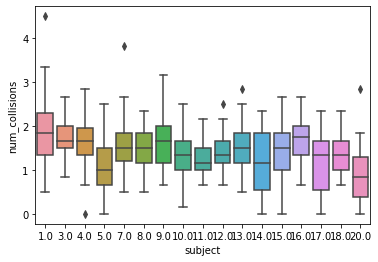

In [39]:
sns.boxplot(x='subject', y='num_collisions', data=df_subjects)

In [23]:
output_csv = pd.DataFrame()
output_csv['Subject'] = df_annot['subject'].astype(int)
output_csv['Subject'] = output_csv['Subject'].astype(str)
output_csv['Device'] = df_annot['device']
output_csv['Rho'] = df_annot['rho']
output_csv['Lambda'] =  df_annot['lam']
output_csv['Display'] = df_annot['hmd']
output_csv['Number_Collisions'] = df_annot['num_collisions']
output_csv.to_csv('time.csv', index=False)

output_csv
rp.summary_cat(output_csv[['Device', 'Rho', 'Lambda', 'Display']])

,Variable,Outcome,Count,Percent
0,Device,monitor_10x16,918,16.67
1,,monitor_06x10,918,16.67
2,,monitor_19x31,918,16.67
3,,headset_06x10,918,16.67
4,,headset_10x16,918,16.67
5,,headset_19x31,918,16.67
6,Rho,headset_500,918,16.67
7,,headset_300,918,16.67
8,,monitor_500,918,16.67
9,,monitor_100,918,16.67


In [24]:
rp.summary_cont(df_subjects["num_collisions"])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,num_collisions,918.0,1.4241,0.6186,0.0204,1.384,1.4642


In [25]:
print(df_annot)

      subject  block  trial  num_collisions       time         device  \
0         1.0    1.0    1.0             3.0  60.000000  headset_06x10   
1         1.0    1.0    2.0             2.0  56.595642  headset_06x10   
2         1.0    1.0    3.0             1.0  18.012695  headset_06x10   
3         1.0    1.0    4.0             1.0  60.000000  headset_06x10   
4         1.0    2.0    0.0             3.0  59.482513  headset_06x10   
...       ...    ...    ...             ...        ...            ...   
2845      9.0   27.0    2.0             1.0   5.316650  monitor_19x31   
2846      9.0   27.0    3.0             0.0   5.416504  monitor_19x31   
2847      9.0   27.0    4.0             4.0   6.733154  monitor_19x31   
2848      9.0   27.0    5.0             2.0  10.849854  monitor_19x31   
2849      9.0   27.0    6.0             2.0   5.216553  monitor_19x31   

              rho           lam      hmd  
0     headset_100  headset_0050  headset  
1     headset_100  headset_0050  head

In [26]:
# SIGNIFICANCE TESTING #
# Non-parametric repeated measures design is tested with a Friedman Chi-square test
# Num-collisions treated as an ordinal variable => considerred a downgrade from interval data
groups = ['device', 'rho', 'lam']

for group in groups:
    c = []
    for a in df_annot[group].unique():
        b = df_annot[df_annot[group]==a]
        c.append(np.array(b.num_collisions))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)

device :  FriedmanchisquareResult(statistic=23.241341991344598, pvalue=8.978560441599353e-06)
rho :  FriedmanchisquareResult(statistic=35.62225789192232, pvalue=1.839606698561611e-08)
lam :  FriedmanchisquareResult(statistic=57.064154786153935, pvalue=4.0614043622917505e-13)


In [27]:
rp.summary_cat(df_annot[[ "device", "rho", "lam", "subject", 'hmd']])  #independent variables

,Variable,Outcome,Count,Percent
0,device,monitor_10x16,918,16.67
1,,monitor_06x10,918,16.67
2,,monitor_19x31,918,16.67
3,,headset_06x10,918,16.67
4,,headset_10x16,918,16.67
5,,headset_19x31,918,16.67
6,rho,headset_500,918,16.67
7,,headset_300,918,16.67
8,,monitor_500,918,16.67
9,,monitor_100,918,16.67


In [28]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'num_collisions')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,*,**,***,***,***
1,headset_10x16,*,1.0,1.0,***,***,***
2,headset_19x31,**,1.0,1.0,***,***,***
3,monitor_06x10,***,***,***,1.0,0.2284,1.0
4,monitor_10x16,***,***,***,0.2284,1.0,0.128753
5,monitor_19x31,***,***,***,1.0,0.128753,1.0


In [29]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.0,***,0.710333,***,***,***
1,headset_300,***,1.0,*,***,***,***
2,headset_500,0.710333,*,1.0,***,***,***
3,monitor_100,***,***,***,1.0,*,0.710333
4,monitor_300,***,***,***,*,1.0,**
5,monitor_500,***,***,***,0.710333,**,1.0


In [30]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,***,***,***,***,***
1,headset_1000,***,1.0,0.244573,***,***,***
2,headset_5000,***,0.244573,1.0,***,***,***
3,monitor_0050,***,***,***,1.0,0.361634,0.244573
4,monitor_1000,***,***,***,0.361634,1.0,0.676472
5,monitor_5000,***,***,***,0.244573,0.676472,1.0


In [31]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot, 'time')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31,monitor_06x10,monitor_10x16,monitor_19x31
0,headset_06x10,1.0,1.0,1.0,***,***,***
1,headset_10x16,1.0,1.0,1.0,***,***,***
2,headset_19x31,1.0,1.0,1.0,***,***,***
3,monitor_06x10,***,***,***,1.0,**,***
4,monitor_10x16,***,***,***,**,1.0,***
5,monitor_19x31,***,***,***,***,***,1.0


In [32]:
rhoPairs

,index,headset_100,headset_300,headset_500,monitor_100,monitor_300,monitor_500
0,headset_100,1.0,1.0,1.0,***,***,***
1,headset_300,1.0,1.0,1.0,***,***,***
2,headset_500,1.0,1.0,1.0,***,***,***
3,monitor_100,***,***,***,1.0,*,***
4,monitor_300,***,***,***,*,1.0,**
5,monitor_500,***,***,***,***,**,1.0


In [33]:
lamPairs

,index,headset_0050,headset_1000,headset_5000,monitor_0050,monitor_1000,monitor_5000
0,headset_0050,1.0,0.853063,0.314589,***,***,***
1,headset_1000,0.853063,1.0,0.853063,***,***,***
2,headset_5000,0.314589,0.853063,1.0,***,***,***
3,monitor_0050,***,***,***,1.0,0.636025,0.328755
4,monitor_1000,***,***,***,0.636025,1.0,0.853063
5,monitor_5000,***,***,***,0.328755,0.853063,1.0


In [34]:
# Repeat for significance values without erroneous h -> monitor comparisons (e.g. h Rho100 vs Monitor Rho 300)
for group in groups:
    c = []
    for a in df_annot_h[group].unique():
        b = df_annot_h[df_annot_h[group]==a]
        c.append(np.array(b.num_collisions))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)

device :  FriedmanchisquareResult(statistic=23.241341991344598, pvalue=8.978560441599353e-06)
rho :  FriedmanchisquareResult(statistic=35.62225789192232, pvalue=1.839606698561611e-08)
lam :  FriedmanchisquareResult(statistic=57.064154786153935, pvalue=4.0614043622917505e-13)


In [35]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_h, 'num_collisions')
devPairs

c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\sbjsm\appdata\local\programs\python\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,index,headset_06x10,headset_10x16,headset_19x31
0,headset_06x10,1.0,**,**
1,headset_10x16,**,1.0,0.529438
2,headset_19x31,**,0.529438,1.0


In [36]:
rhoPairs

,index,headset_100,headset_300,headset_500
0,headset_100,1.0,***,0.308986
1,headset_300,***,1.0,**
2,headset_500,0.308986,**,1.0


In [37]:
lamPairs

,index,headset_0050,headset_1000,headset_5000
0,headset_0050,1.0,***,***
1,headset_1000,***,1.0,*
2,headset_5000,***,*,1.0


In [38]:
for group in groups:
    c = []
    for a in df_annot_h[group].unique():
        b = df_annot_h[df_annot_h[group]==a]
        c.append(np.array(b.time))
    results = friedmanchisquare(c[0], c[1], c[2])
    print(group , ': ' , results)

device :  FriedmanchisquareResult(statistic=1.972610243770365, pvalue=0.3729521611380535)
rho :  FriedmanchisquareResult(statistic=2.439331689949374, pvalue=0.2953288360523903)
lam :  FriedmanchisquareResult(statistic=4.596337797213116, pvalue=0.10044259601444566)


In [ ]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_h, 'time')
devPairs

In [ ]:
rhoPairs

In [ ]:
lamPairs

In [ ]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_m, 'num_collisions')
devPairs

In [ ]:
rhoPairs

In [ ]:
lamPairs

In [ ]:
devPairs, rhoPairs, lamPairs = find_sig_pairings(df_annot_m, 'time')
devPairs

In [ ]:
rhoPairs

In [ ]:
lamPairs

In [ ]:
generate_all(df_subjects)

In [ ]:
import pulse2percept as p2p
p2p.viz.scatter_correlation(df_subjects['time'], df_subjects['num_collisions'])

In [41]:
for subject in df_annot['subject'].unique():
    print( "{:.3f}".format(df_annot[df_annot['subject']==subject]['num_collisions'].mean()),',', 
          "{:.3f}".format(df_annot[df_annot['subject']==subject]['num_collisions'].std()), ',',
         "{:.3f}".format(df_annot[df_annot['subject']==subject]['time'].mean()), ',',
         "{:.3f}".format(df_annot[df_annot['subject']==subject]['time'].std()))

1.843 , 1.549 , 28.781 , 14.390
1.747 , 0.926 , 21.836 , 11.103
1.639 , 1.083 , 18.750 , 15.115
1.065 , 1.031 , 10.880 , 5.015
1.596 , 1.247 , 18.855 , 12.490
1.441 , 0.821 , 12.297 , 10.159
1.670 , 1.153 , 14.568 , 8.742
1.333 , 0.938 , 11.420 , 9.657
1.299 , 0.873 , 19.065 , 13.713
1.444 , 0.869 , 12.239 , 8.907
1.525 , 1.083 , 18.446 , 9.938
1.167 , 1.015 , 16.213 , 9.489
1.340 , 1.071 , 16.365 , 11.153
1.648 , 0.897 , 12.456 , 10.697
1.191 , 1.023 , 15.711 , 7.633
1.392 , 0.933 , 16.813 , 11.870
0.870 , 0.939 , 17.428 , 7.550
